Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using mpiexec in global path
Warning! Using python in global path


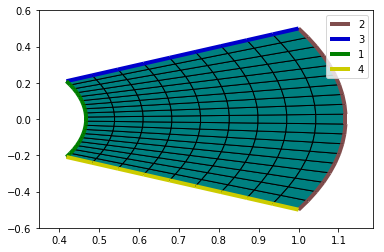

In [1]:
import amfe
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
from scipy.sparse import linalg as splinalg
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib notebook

mshfile = amfe.amfe_dir('meshes/test_meshes/ring_connection.msh')



m = amfe.Mesh()
m.import_msh(mshfile)



amfe.plot_mesh(m)
plt.show()

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 171 elements and 400 dofs.
Time taken for preallocation: 0.00 seconds.


C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


The K, M and f are ordered according its original dofs order


C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


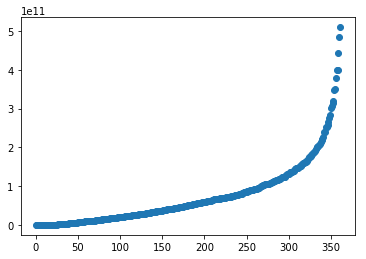

In [2]:
my_comp = amfe.CraigBamptonComponent()
my_comp.set_mesh_obj(m)

my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain(6,my_material)
my_comp.apply_neumann_boundaries(2,1e8, 'normal')

K, f = my_comp.assembly_class.assemble_k_and_f()
K_, f = my_comp.assembly_class.assemble_k_and_f_neumann()
M = my_comp.assembly_class.assemble_m()


dirsub = m.get_submesh('phys_group', 1)
cyclic_low = m.get_submesh('phys_group', 3)
cyclic_high = m.get_submesh('phys_group', 4)


id_matrix = my_comp.assembly_class.id_matrix
dir_dofs = amfe.get_dirichlet_dofs(dirsub, direction ='xy', id_matrix=id_matrix)
low_dofs = amfe.get_dirichlet_dofs(cyclic_low, direction ='xy', id_matrix=id_matrix)
high_dofs = amfe.get_dirichlet_dofs(cyclic_high, direction ='xy', id_matrix=id_matrix)

K, M, f = my_comp.insert_dirichlet_boundary_cond(K,M,f,dir_dofs, value = 0.0)
K_mod, M_mod, f_mod = my_comp.insert_cyclic_symm_boundary_cond(K, M, f, low_dofs = low_dofs, high_dofs = high_dofs, theta = 0.0)    


omega, V_dynamic = linalg.eig(K_mod.todense(), M_mod.todense())
#omega, V_dynamic = splinalg.eigs(K_mod, k=30, M = M_mod, sigma=1.0,  which='SM')

indexes = np.argsort(omega)
V_dynamic = V_dynamic [:,indexes]
plt.plot(omega[indexes],'o')
plt.show()

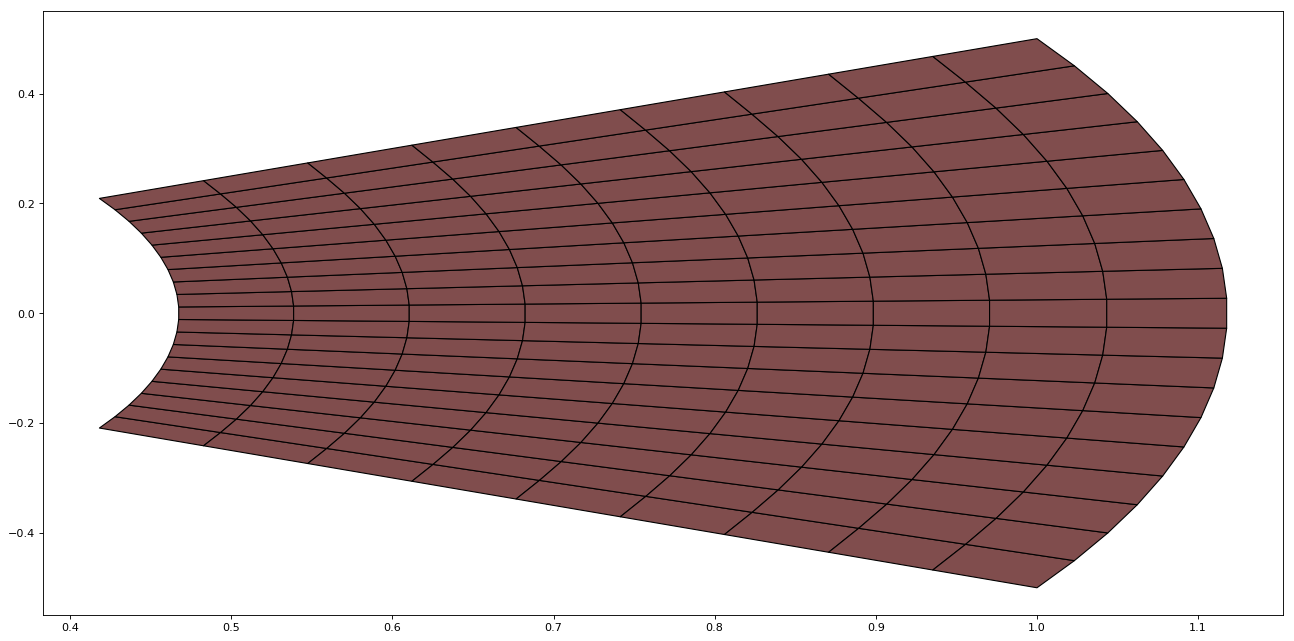

In [3]:
mode = 21
def get_mode(mode):
    V_dynamic2 = V_dynamic
    mode_shapes = V_dynamic2
    my_comp.u_output = []
    my_comp.u_output.append(0*mode_shapes[:,mode])
    my_comp.u_output.append(mode_shapes[:,mode])
    return my_comp


@interact(scale=(-4,5,0.4),mode=(0,30,1))   
def plot(scale=0,mode=0):
    my_comp = get_mode(mode)
    fig, ax1 = plt.subplots(1, figsize=(20,10), dpi=80)
    amfe.plot_system_solution(my_comp,ax=ax1,factor=1.0*scale)
    
    plt.show()